In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 37222 
    Total predicted counts          : 37213.94
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.92 s, sys: 19.9 ms, total: 3.94 s
Wall time: 3.94 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37107 
    Total predicted counts          : 37257.94
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36990 
    Total predicted counts          : 37192.34
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 37115 
    Total predicted counts          : 37293.94
    Total off counts                : 101840.00

    Total background counts         : 20368.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.58

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_28 

    Total counts                    : 37103 
    Total predicted counts          : 37335.94
    Total off counts                : 102050.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_62 

    Total counts                    : 37490 
    Total predicted counts          : 37227.74
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.80

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_63 

    Total counts                    : 37159 
    Total predicted counts          : 37209.14
    Total off counts                : 101416.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_85 

    Total counts                    : 37208 
    Total predicted counts          : 37162.74
    Total off counts                : 101184.00

    Total background counts         : 20236.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 37073 
    Total predicted counts          : 37211.54
    Total off counts                : 101428.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 36893 
    Total predicted counts          : 37318.34
    Total off counts                : 101962.00

    Total background counts         : 20392.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.97

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 37429 
    Total predicted counts          : 37267.74
    Total off counts                : 101709.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_132 

    Total counts                    : 37585 
    Total predicted counts          : 37289.74
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_133 

    Total counts                    : 37011 
    Total predicted counts          : 37253.74
    Total off counts                : 101639.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_149 

    Total counts                    : 37389 
    Total predicted counts          : 37178.54
    Total off counts                : 101263.00

    Total background counts         : 20252.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_150 

    Total counts                    : 37089 
    Total predicted counts          : 37235.54
    Total off counts                : 101548.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 37146 
    Total predicted counts          : 37341.54
    Total off counts                : 102078.00

    Total background counts         : 20415.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 37067 
    Total predicted counts          : 37135.54
    Total off counts                : 101048.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_189 

    Total counts                    : 37323 
    Total predicted counts          : 37189.74
    Total off counts                : 101319.00

    Total background counts         : 20263.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.79

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_190 

    Total counts                    : 37330 
    Total predicted counts          : 37385.74
    Total off counts                : 102299.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_207 

    Total counts                    : 37265 
    Total predicted counts          : 37179.34
    Total off counts                : 101267.00

    Total background counts         : 20253.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.19

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 37042 
    Total predicted counts          : 37304.34
    Total off counts                : 101892.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 37486 
    Total predicted counts          : 37176.74
    Total off counts                : 101254.00

    Total background counts         : 20250.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_230 

    Total counts                    : 37512 
    Total predicted counts          : 37317.34
    Total off counts                : 101957.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 37100 
    Total predicted counts          : 37294.54
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_253 

    Total counts                    : 36967 
    Total predicted counts          : 37343.54
    Total off counts                : 102088.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 37203 
    Total predicted counts          : 37266.54
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 37481 
    Total predicted counts          : 37235.54
    Total off counts                : 101548.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_311 

    Total counts                    : 37271 
    Total predicted counts          : 37302.74
    Total off counts                : 101884.00

    Total background counts         : 20376.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_312 

    Total counts                    : 37107 
    Total predicted counts          : 37213.14
    Total off counts                : 101436.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 37365 
    Total predicted counts          : 37148.34
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 37291 
    Total predicted counts          : 37214.14
    Total off counts                : 101441.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 37053 
    Total predicted counts          : 37328.34
    Total off counts                : 102012.00

    Total background counts         : 20402.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.74

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 37300 
    Total predicted counts          : 37303.74
    Total off counts                : 101889.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 37102 
    Total predicted counts          : 37194.34
    Total off counts                : 101342.00

    Total background counts         : 20268.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.46

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 37462 
    Total predicted counts          : 37364.34
    Total off counts                : 102192.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 37289 
    Total predicted counts          : 37211.34
    Total off counts                : 101427.00

    Total background counts         : 20285.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.36

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 37211 
    Total predicted counts          : 37243.74
    Total off counts                : 101589.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_468 

    Total counts                    : 37105 
    Total predicted counts          : 37254.94
    Total off counts                : 101645.00

    Total background counts         : 20329.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_469 

    Total counts                    : 37161 
    Total predicted counts          : 37231.74
    Total off counts                : 101529.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_496 

    Total counts                    : 37261 
    Total predicted counts          : 37210.34
    Total off counts                : 101422.00

    Total background counts         : 20284.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.89

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 37062 
    Total predicted counts          : 37289.74
    Total off counts                : 101819.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_518 

    Total counts                    : 36929 
    Total predicted counts          : 37261.74
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_519 

    Total counts                    : 37295 
    Total predicted counts          : 37228.94
    Total off counts                : 101515.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_544 

    Total counts                    : 37204 
    Total predicted counts          : 37253.54
    Total off counts                : 101638.00

    Total background counts         : 20327.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.82

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_545 

    Total counts                    : 37429 
    Total predicted counts          : 37359.34
    Total off counts                : 102167.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_566 

    Total counts                    : 37358 
    Total predicted counts          : 37221.34
    Total off counts                : 101477.00

    Total background counts         : 20295.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_567 

    Total counts                    : 37502 
    Total predicted counts          : 37305.34
    Total off counts                : 101897.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_586 

    Total counts                    : 37121 
    Total predicted counts          : 37375.14
    Total off counts                : 102246.00

    Total background counts         : 20449.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_587 

    Total counts                    : 37159 
    Total predicted counts          : 37346.54
    Total off counts                : 102103.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 37502 
    Total predicted counts          : 37249.34
    Total off counts                : 101617.00

    Total background counts         : 20323.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 37149 
    Total predicted counts          : 37186.54
    Total off counts                : 101303.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_625 

    Total counts                    : 36918 
    Total predicted counts          : 37331.54
    Total off counts                : 102028.00

    Total background counts         : 20405.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_626 

    Total counts                    : 36858 
    Total predicted counts          : 37280.94
    Total off counts                : 101775.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_643 

    Total counts                    : 37248 
    Total predicted counts          : 37371.34
    Total off counts                : 102227.00

    Total background counts         : 20445.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 37072 
    Total predicted counts          : 37289.94
    Total off counts                : 101820.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_668 

    Total counts                    : 37167 
    Total predicted counts          : 37308.94
    Total off counts                : 101915.00

    Total background counts         : 20383.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.66

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_669 

    Total counts                    : 37271 
    Total predicted counts          : 37233.74
    Total off counts                : 101539.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_699 

    Total counts                    : 37526 
    Total predicted counts          : 37209.94
    Total off counts                : 101420.00

    Total background counts         : 20284.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 25.12

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_700 

    Total counts                    : 37190 
    Total predicted counts          : 37267.54
    Total off counts                : 101708.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_732 

    Total counts                    : 37580 
    Total predicted counts          : 37301.14
    Total off counts                : 101876.00

    Total background counts         : 20375.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.30

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_733 

    Total counts                    : 37053 
    Total predicted counts          : 37122.14
    Total off counts                : 100981.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_761 

    Total counts                    : 37013 
    Total predicted counts          : 37161.14
    Total off counts                : 101176.00

    Total background counts         : 20235.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_762 

    Total counts                    : 37056 
    Total predicted counts          : 37229.14
    Total off counts                : 101516.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_792 

    Total counts                    : 37371 
    Total predicted counts          : 37222.74
    Total off counts                : 101484.00

    Total background counts         : 20296.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.26

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 37153 
    Total predicted counts          : 37303.34
    Total off counts                : 101887.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_825 

    Total counts                    : 37163 
    Total predicted counts          : 37047.74
    Total off counts                : 100609.00

    Total background counts         : 20121.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.87

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_826 

    Total counts                    : 37383 
    Total predicted counts          : 37251.14
    Total off counts                : 101626.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_857 

    Total counts                    : 36901 
    Total predicted counts          : 37255.74
    Total off counts                : 101649.00

    Total background counts         : 20329.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.39

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_858 

    Total counts                    : 37201 
    Total predicted counts          : 37240.34
    Total off counts                : 101572.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_889 

    Total counts                    : 37507 
    Total predicted counts          : 37188.94
    Total off counts                : 101315.00

    Total background counts         : 20263.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.24

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_890 

    Total counts                    : 37181 
    Total predicted counts          : 37281.74
    Total off counts                : 101779.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_921 

    Total counts                    : 37547 
    Total predicted counts          : 37251.54
    Total off counts                : 101628.00

    Total background counts         : 20325.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.22

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_922 

    Total counts                    : 37075 
    Total predicted counts          : 37270.94
    Total off counts                : 101725.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_947 

    Total counts                    : 37120 
    Total predicted counts          : 37156.54
    Total off counts                : 101153.00

    Total background counts         : 20230.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.32

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_948 

    Total counts                    : 37086 
    Total predicted counts          : 37205.14
    Total off counts                : 101396.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_978 

    Total counts                    : 36961 
    Total predicted counts          : 37110.74
    Total off counts                : 100924.00

    Total background counts         : 20184.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 37378 
    Total predicted counts          : 37244.74
    Total off counts                : 101594.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

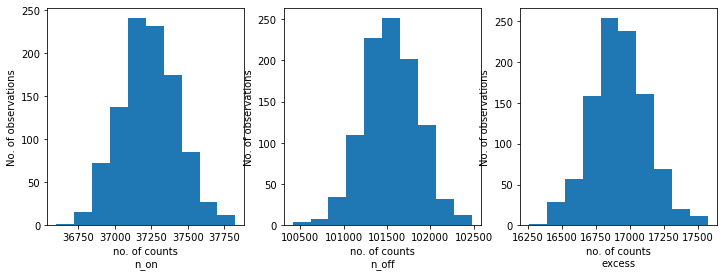

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 2min, sys: 83.9 ms, total: 2min
Wall time: 2min


In [15]:
results

[{'index': 2.210312649457622, 'amplitude': 1.2999148010805192e-12},
 {'index': 2.221794649297089, 'amplitude': 1.2624720633438962e-12},
 {'index': 2.226917472297916, 'amplitude': 1.2692828741968535e-12},
 {'index': 2.2243294724809273, 'amplitude': 1.2760460667160836e-12},
 {'index': 2.230487848445283, 'amplitude': 1.289071814190189e-12},
 {'index': 2.2176425247166542, 'amplitude': 1.2822089037710306e-12},
 {'index': 2.216192794914367, 'amplitude': 1.2905649230744224e-12},
 {'index': 2.2181788794836295, 'amplitude': 1.2844505300569238e-12},
 {'index': 2.2148364595219476, 'amplitude': 1.2941866637630027e-12},
 {'index': 2.2099732084774226, 'amplitude': 1.3004987871954154e-12},
 {'index': 2.2172085439732427, 'amplitude': 1.3021990683930246e-12},
 {'index': 2.2163893701043262, 'amplitude': 1.3029965681849181e-12},
 {'index': 2.2152326224488714, 'amplitude': 1.3060639898614054e-12},
 {'index': 2.218580088362964, 'amplitude': 1.2638387722092008e-12},
 {'index': 2.216428727442129, 'amplitude'

index: 2.2200836437831413 += 0.0065358002511280945


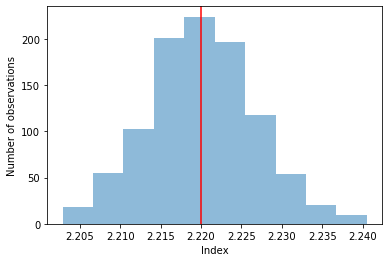

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2886653012289732e-12 += 1.400903308050667e-14


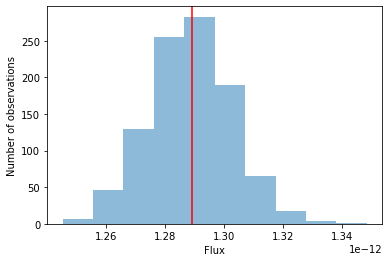

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")